# Lesson 39: Performing regressions

(c) 2018 Justin Bois. With the exception of pasted graphics, where the source is noted, this work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

This document was prepared at [Caltech](http://www.caltech.edu) with financial support from the [Donna and Benjamin M. Rosen Bioengineering Center](http://rosen.caltech.edu).

<img src="caltech_rosen.png">

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](l39_regressions.ipynb).*

<br /><br />

In [1]:
import numpy as np
import pandas as pd

# We'll use scipy.optimize.curve_fit to do the nonlinear regression
import scipy.optimize

import altair as alt

## Bicoid and its gradient

In this tutorial, we will perform a nonlinear regression on data from a classic paper by Driever and Nüsslein-Volhard ([*Cell*, **54**, 95–104, 1988](https://doi.org/10.1016/0092-8674(88)90183-3)).  In this paper, the authors identified Bicoid the first **morphogen**, a chemical substance that controls cell fate in a concentration dependent manner.  In the context of *Drosophila* embryogenesis, Bicoid (Bcd) exhibits a concentration gradient, with a high concentration in the anterior region of the embryo and a low concentration in posterior region.  Below is an image of the Bicound gradient from an immunostaining experiment from their paper.

<img src="bcd_immunostain.png" width="300"/>

Driever and Nüsslein-Volhard quantified this gradient by measuring the darkness of the immunostain as a function of distance between the anterior and posterior of the embryo.  Our goal in this lesson is to perform a regression to get the characteristic length of the Bcd gradient.  Specifically, based on physical modeling we will not go into here, we expect the Bcd gradient to be exponential, or

\begin{align}
c(x) = c_0 \mathrm{e}^{-x/\lambda},
\end{align}

where $c(x)$ is the Bcd concentration at position $x$, with $x = 0$ at the anterior and $x = 1$ at the posterior.  I.e., $x$ is in units of the total AP axis length.  The Bcd concentration at the anterior is $c_0$, and the decay length, or characteristic length, of the gradient is $\lambda$.  We assume that the intensity of the immunostain is 

\begin{align}
I = a + b c,
\end{align}

where $a$ is the background signal and the immunostain intensity varies linearly with Bcd concentration.  Thus, Bcd gradient, as visualized by immunostaining, is

\begin{align}
I(x) = a + I_0\mathrm{e}^{-x/\lambda}.\\[1em]
\phantom{blah}
\end{align}

## The data set

We will use the original data from Driever and Nüsslein-Volhard, available in `~/git/data/bcd_gradient.csv`.  We will first look at the file to see how we should import it.

In [2]:
!head data/bcd_gradient.csv

# Data taken from Fig. 3A of Driever and Nuesslein-Volhard, Cell,
# 54, 95-104, 1988.  This is the normalized immunostain intensity
# as a function of distance along the A-P axis in a wild type
# embryo.
fractional distance from anterior,[bcd] (a.u.)
0.0026446672455988007,0.86309692805632854
0.034222783610957611,0.86309692805632854
0.068445567221915221,0.74572710237919493
0.10262887818741613,0.65487479416273942
0.13420699455277493,0.54511384929873385


We see that this is a CSV file with two columns and comments preceded by `#`.  The header row is given.  So, we know how to use `pd.read_csv` to import the data.

In [3]:
# Import data set
df = pd.read_csv('data/bcd_gradient.csv', comment='#')

# Inspect DataFrame
df.head()

,fractional distance from anterior,[bcd] (a.u.)
0,0.002645,0.863097
1,0.034223,0.863097
2,0.068446,0.745727
3,0.102629,0.654875
4,0.134207,0.545114


Because Altair does not like brackets and periods, let's rename the bcd concentration column.

In [4]:
df = df.rename(columns={'[bcd] (a.u.)': 'bcd'})

Let's plot the data to see what we are dealing with.

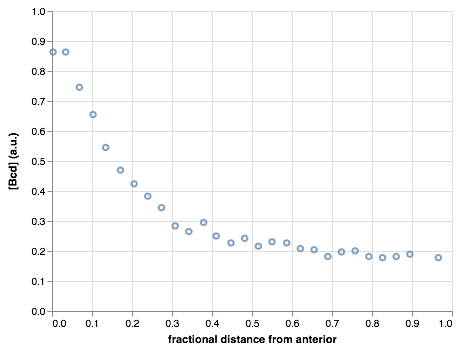

In [5]:
dots = alt.Chart(df
    ).mark_point(
    ).encode(
        x='fractional distance from anterior:Q',
        y=alt.Y('bcd:Q', title='[Bcd] (a.u.)', scale=alt.Scale(domain=[0, 1])))

dots

## Using `scipy.optimize.curve_fit()` to perform nonlinear regression

We will use scipy.optimize.curve_fit to preform the regression. Since this is our first time, let's read the doc string to figure out how to use it.

In [6]:
scipy.optimize.curve_fit?

Signature: scipy.optimize.curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)
Docstring:
Use non-linear least squares to fit a function, f, to data.

Assumes ``ydata = f(xdata, *params) + eps``

Parameters
----------
f : callable
    The model function, f(x, ...).  It must take the independent
    variable as the first argument and the parameters to fit as
    separate remaining arguments.
xdata : An M-length sequence or an (k,M)-shaped array for functions with k predictors
    The independent variable where the data is measured.
ydata : M-length sequence
    The dependent data --- nominally f(xdata, ...)
p0 : None, scalar, or N-length sequence, optional
    Initial guess for the parameters.  If None, then the initial
    values will all be 1 (if the number of parameters for the function
    can be determined using introspection, otherwise a ValueError
    is raised).
sigma : None or M-length sequ

We see that the function prototype is 

    scipy.optimize.curve_fit(f, xdata, ydata, p0=None)

and that `f` is the function we wish to use to fit our data.  The function `f` must have a prototype `f(t, *p)`, where the first parameter is the dependent variable and the remaining parameters are those to be determined by performing the regression.

### Defining the model function

So, our first step for using `scipy.optimize.curvefit()` is to define the fit function `f`, which we will call `bcd_gradient_model`.  We have three parameters, $I_0$, $a$, and $\lambda$.

In [7]:
def bcd_gradient_model_first_try(x, I_0, a, lam):
    """Model for Bcd gradient: exponential decay plus background"""
    return a + I_0 * np.exp(-x/lam)

Notice that we used `lam` as the name of the parameter $\lambda$.  This is because `lambda` is a keyword in Python.  **Never** name a variable `lambda`.  This is so important, I'm going to make the point more fervently, even though we already made it in a previous lesson.

<div class="alert alert-danger">
<p>**Never** name a Python variable the same as a keyword!</p><br />

To see what the keywords are, do this:

    `import keyword; print(keyword.kwlist)`
</div>

There is a problem with our function, though.  It is really only defined is all of its arguments are positive.  We therefore should assure that all arguments are positive.

In [8]:
def bcd_gradient_model(x, I_0, a, lam):
    """Model for Bcd gradient: exponential decay plus background"""
    
    if np.any(np.array(x) < 0):
        raise RuntimeError('All values of `x` must be >= zero.')
    if np.any(np.array([I_0, a, lam]) < 0):
        raise RuntimeError('All parameters must be >= 0.')
    
    return a + I_0 * np.exp(-x / lam)

### Initial guess

With our fit function in place, we now need to supply initial guesses for the parameter values, given by the kwarg `p0`. (We don't have to do this, but `scipy.optimize.curve_fit()` will guess a value of 1 for all parameters, which is generally not a good idea. You should always explicitly supply your own initial guesses.) In looking at the plot, we see that we indeed have a nonzero background signal, somewhere around $a \approx 0.2$.  We also see that $I_0 \approx 0.9$ and $\lambda \approx 0.3$.  We would normally use these as our approximate guesses, but to show an additional lesson, we will guess $\lambda = 1$, making the solver do a little more work.

In [9]:
# Specify initial guess
I_0_guess = 0.9
a_guess = 0.2
lam_guess = 1.0

# Construct initial guess array
p0 = np.array([I_0_guess, a_guess, lam_guess])

### Performing the regression (first try)

When doing the curve fit, we see that it returns the optimal parameter values as well as an estimate of the covariance matrix. For reasons I will not discuss here, this covariance matrix has some assumptions under the hood that are not always appropriate, so we will just ignore it.
Now we're ready to do the regression!

In [10]:
# Do curve fit, but dump covariance into dummy variable
p, _ = scipy.optimize.curve_fit(bcd_gradient_model,
                                df['fractional distance from anterior'],
                                df['bcd'],
                                p0=p0)

# Print the results
print("""
I_0 = {0:.2f}
  a = {1:.2f}
  λ = {2:.2f}
""".format(*tuple(p)))

RuntimeError: All parameters must be >= 0.

Oh no!  We got an exception that we had negative parameters! This occurred because under the hood, `scipy.optimize.curve_fit()` tries many sets of parameter values as it searches for those that bring the theoretical curve closest to the observed data. (It is way more complicated than that, but we won't get into that here.)

### Performing the regression (second try)

At this point, we have a few options.
1. Take out our error checking on positivity of parameter. The resulting curve with negative values of c or d will be so far off, the curve fit routine should come back toward physical parameter values after an excursion into non-physicality.
2. Try using something other than `scipy.optimize.curve_fit()`.
3. Adjust our theoretical function by using the logarithm of the parameter values instead of the parameter values themselves. This ensures that all parameter are positive.

I think option 1 is off the table. We generally want to avoid "shoulds" when programming. We do not want to just hope that the solver will work, even though nonphysical parameter values are encountered.

Depending on how many times I will need to do a particular type of curve fit, I typically prefer option 2. We will not do this in the bootcamp, but I often use a technique called Markov chain Monte Carlo.

We'll use option 3. This still allows the solver to consider a smooth function of the parameter values. So, let's define a function that takes the logarithms of the parameters and input.

In [11]:
def bcd_gradient_model_log_params(x, log_I_0, log_a, log_lam):
    """
    Model for Bcd gradient: exponential decay plus 
    background with log parameters.
    """
    
    # Exponentiate parameters
    I_0, a, lam = np.exp(np.array([log_I_0, log_a, log_lam]))
    
    return bcd_gradient_model(x, I_0, a, lam)

Now let's try our curve fit again. We need to make sure we convert our initial guesses into logarithms. Remember, now the solver will be working with logarithms of parameters.

In [12]:
# Construct initial guess array
log_p0 = np.log(p0)

# Do curve fit, but dump covariance into dummy variable
log_p, _ = scipy.optimize.curve_fit(bcd_gradient_model_log_params, 
                                    df['fractional distance from anterior'], 
                                    df['bcd'], 
                                    p0=log_p0)

# Get the optimal parameter values
p = np.exp(log_p)

# Print the results
print("""
I_0 = {0:.2f}
  a = {1:.2f}
  λ = {2:.2f}
""".format(*tuple(p)))


I_0 = 0.77
  a = 0.17
  λ = 0.19



### Plotting the result

We can now generate a smooth curve defined by the optimal parameters we just found and plot it along with the data.  To do this, we make a densely sampled array of $x$ values and then compute the fitting function for these values.

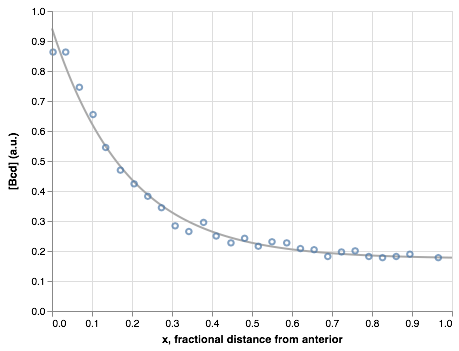

In [13]:
# Smooth x values (400 values between zero and one)
x_smooth = np.linspace(0, 1, 400)

# Compute smooth curve
bcd_smooth = bcd_gradient_model(x_smooth, *p)

# Make into a data frame
df_smooth = pd.DataFrame({'x': x_smooth, 'bcd': bcd_smooth})

# Smooth line
line = alt.Chart(df_smooth
    ).mark_line(
        color='darkgray',
    ).encode(
        x='x',
        y='bcd')

line + dots

So, we have determined the length scale of the Bcd gradient: about 20% of the total embryo length.